In [ ]:
!pip install rasterio scikit-image albumentations segmentation-models-pytorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
import zipfile
import os

# Path to the uploaded zip file (adjust name if needed)
zip_path = "/content/data-20250714T200605Z-1-001.zip"
extract_path = "/content/data"

# Extract the zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(" Extraction complete. Files are now in:", extract_path)


 Extraction complete. Files are now in: /content/data


In [37]:
import glob

# List .tif image files
image_files = sorted(glob.glob("/content/data/**/*.tif", recursive=True))

print(f"Found {len(image_files)} .tif files. Here are a few examples:")
for f in image_files[:10]:
    print("  ", f)


Found 306 .tif files. Here are a few examples:
   /content/data/data/images/0.tif
   /content/data/data/images/1.tif
   /content/data/data/images/10.tif
   /content/data/data/images/100.tif
   /content/data/data/images/101.tif
   /content/data/data/images/102.tif
   /content/data/data/images/103.tif
   /content/data/data/images/104.tif
   /content/data/data/images/105.tif
   /content/data/data/images/106.tif


In [38]:
import glob

# Check for PNG label masks (not .tif)
label_files = sorted(glob.glob("/content/data/data/labels/*.png"))
print(f"Found {len(label_files)} label .png files.")

# Show a few examples
for f in label_files[:10]:
    print("  ", f)


Found 456 label .png files.
   /content/data/data/labels/0.png
   /content/data/data/labels/1.png
   /content/data/data/labels/10.png
   /content/data/data/labels/100.png
   /content/data/data/labels/100_184.png
   /content/data/data/labels/101.png
   /content/data/data/labels/101_89.png
   /content/data/data/labels/102.png
   /content/data/data/labels/102_179.png
   /content/data/data/labels/103.png


In [40]:
import os
from glob import glob

# Load .tif images and .png masks
image_paths_all = sorted(glob("/content/data/data/images/*.tif"))
label_paths_all = sorted(glob("/content/data/data/labels/*.png"))

# Map file numbers (without extension) to full paths
image_map = {os.path.splitext(os.path.basename(p))[0]: p for p in image_paths_all}
label_map = {os.path.splitext(os.path.basename(p))[0]: p for p in label_paths_all if "_" not in os.path.basename(p)}  # Exclude label variants with "_"

# Match keys that exist in both maps
matched_keys = sorted(set(image_map.keys()) & set(label_map.keys()))
image_paths = [image_map[k] for k in matched_keys]
label_paths = [label_map[k] for k in matched_keys]

print(f"Matched {len(image_paths)} image-label pairs.")
for i in range(5):
    print(f"  Image: {image_paths[i]}\n  Label: {label_paths[i]}")


Matched 306 image-label pairs.
  Image: /content/data/data/images/0.tif
  Label: /content/data/data/labels/0.png
  Image: /content/data/data/images/1.tif
  Label: /content/data/data/labels/1.png
  Image: /content/data/data/images/10.tif
  Label: /content/data/data/labels/10.png
  Image: /content/data/data/images/100.tif
  Label: /content/data/data/labels/100.png
  Image: /content/data/data/images/101.tif
  Label: /content/data/data/labels/101.png


In [41]:
import numpy as np
import rasterio
import cv2
from tqdm import tqdm
import os

# Output directories
save_dir_X = "/content/preprocessed/X"
save_dir_Y = "/content/preprocessed/Y"
os.makedirs(save_dir_X, exist_ok=True)
os.makedirs(save_dir_Y, exist_ok=True)

# Band-wise normalization function
def normalize_bandwise(img):
    norm_img = np.zeros_like(img, dtype=np.float32)
    for i in range(img.shape[0]):
        band = img[i]
        norm_img[i] = (band - band.mean()) / (band.std() + 1e-6)
    return norm_img

# Process and save all pairs
for i, (img_path, label_path) in enumerate(tqdm(zip(image_paths, label_paths), total=len(image_paths), desc="Saving .npy files")):
    # Load and normalize image
    with rasterio.open(img_path) as src:
        image = src.read().astype(np.float32)  # shape: (12, 128, 128)
    image = normalize_bandwise(image)

    # Load label as grayscale and binarize
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    label = (label > 0).astype(np.uint8)  # Convert to binary mask

    # Save .npy files
    np.save(f"{save_dir_X}/{i:03}.npy", image)
    np.save(f"{save_dir_Y}/{i:03}.npy", label)

print("All normalized images and binary masks saved as .npy files.")


Saving .npy files:   0%|          | 0/306 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
Saving .npy files: 100%|██████████| 306/306 [00:01<00:00, 163.78it/s]

All normalized images and binary masks saved as .npy files.


In [44]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np

class WaterDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        x = np.load(self.image_paths[idx])              # shape: (12, 128, 128)
        y = np.load(self.label_paths[idx])              # shape: (128, 128)
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(0)  # shape: (1, 128, 128)

        if self.transform:
            x, y = self.transform(x, y)

        return x, y

# Load .npy paths
from glob import glob
import os

X_paths = sorted(glob("/content/preprocessed/X/*.npy"))
Y_paths = sorted(glob("/content/preprocessed/Y/*.npy"))

# Confirm matching
assert len(X_paths) == len(Y_paths), "Mismatch between images and labels!"
print(f"Loaded {len(X_paths)} samples")

# Create dataset and DataLoader
dataset = WaterDataset(X_paths, Y_paths)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)


Loaded 306 samples


In [56]:
import torch.nn.functional as F
import torch.nn as nn
import torch

class MyConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.01)
        self.bias = nn.Parameter(torch.zeros(out_channels))
        self.padding = padding

    def forward(self, x):
        return F.conv2d(x, self.weight, self.bias, padding=self.padding)

class MyReLU(nn.Module):
    def forward(self, x):
        return torch.clamp(x, min=0.0)

class MyMaxPool2D(nn.Module):
    def __init__(self, kernel_size=2):
        super().__init__()
        self.kernel_size = kernel_size

    def forward(self, x):
        return F.max_pool2d(x, self.kernel_size)

class MyUpsample(nn.Module):
    def __init__(self, scale_factor=2):
        super().__init__()
        self.scale_factor = scale_factor

    def forward(self, x):
        return F.interpolate(x, scale_factor=self.scale_factor, mode='bilinear', align_corners=False)

class CustomUNet(nn.Module):
    def __init__(self, in_channels=12, out_channels=1):
        super().__init__()

        self.conv1 = MyConv2D(in_channels, 32)
        self.relu1 = MyReLU()
        self.conv2 = MyConv2D(32, 64)
        self.relu2 = MyReLU()

        self.pool1 = MyMaxPool2D()

        self.conv3 = MyConv2D(64, 128)
        self.relu3 = MyReLU()

        self.up1 = MyUpsample()
        self.conv4 = MyConv2D(128, 64)
        self.relu4 = MyReLU()

        self.up2 = MyUpsample()
        self.conv5 = MyConv2D(64, 32)
        self.relu5 = MyReLU()

        self.final = MyConv2D(32, out_channels)

    def forward(self, x):
        x1 = self.relu1(self.conv1(x))
        x2 = self.relu2(self.conv2(x1))
        x3 = self.pool1(x2)

        x4 = self.relu3(self.conv3(x3))

        x5 = self.up1(x4)
        x5 = self.relu4(self.conv4(x5))

        x6 = self.up2(x5)
        x6 = self.relu5(self.conv5(x6))

        out = self.final(x6)
        out = F.interpolate(out, size=(128, 128), mode='bilinear', align_corners=False)  # fix output size
        return out


In [54]:
def sigmoid_output_to_binary(pred, threshold=0.5):
    return (torch.sigmoid(pred) > threshold).float()

def dice_coef(pred, target, eps=1e-6):
    pred = sigmoid_output_to_binary(pred)
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3))
    return ((2. * intersection + eps) / (union + eps)).mean()

def iou_score(pred, target, eps=1e-6):
    pred = sigmoid_output_to_binary(pred)
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) - intersection
    return ((intersection + eps) / (union + eps)).mean()

def f1_score(pred, target, eps=1e-6):
    pred = sigmoid_output_to_binary(pred)
    tp = (pred * target).sum(dim=(1, 2, 3))
    fp = (pred * (1 - target)).sum(dim=(1, 2, 3))
    fn = ((1 - pred) * target).sum(dim=(1, 2, 3))
    return ((2 * tp + eps) / (2 * tp + fp + fn + eps)).mean()


In [59]:
import copy

# Re-init model and optimizer
model = CustomUNet(in_channels=12, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = dice_loss

# Early stopping
best_model = None
best_dice = 0
patience = 5
wait = 0

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    total_f1 = 0.0
    total_dice = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_iou += iou_score(pred, y).item()
        total_f1 += f1_score(pred, y).item()
        total_dice += dice_coef(pred, y).item()

    avg_loss = total_loss / len(train_loader)
    avg_iou = total_iou / len(train_loader)
    avg_f1 = total_f1 / len(train_loader)
    avg_dice = total_dice / len(train_loader)

    print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | IoU: {avg_iou:.4f} | F1: {avg_f1:.4f} | Dice: {avg_dice:.4f}")

    # Early stopping logic
    if avg_dice > best_dice:
        best_dice = avg_dice
        best_model = copy.deepcopy(model.state_dict())
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load best model after training
model.load_state_dict(best_model)
print("Best model loaded.")


Epoch 01 | Loss: 0.6761 | IoU: 0.2390 | F1: 0.3186 | Dice: 0.3186
Epoch 02 | Loss: 0.6335 | IoU: 0.2632 | F1: 0.3490 | Dice: 0.3490
Epoch 03 | Loss: 0.5589 | IoU: 0.3131 | F1: 0.3923 | Dice: 0.3923
Epoch 04 | Loss: 0.5160 | IoU: 0.3648 | F1: 0.4509 | Dice: 0.4509
Epoch 05 | Loss: 0.4237 | IoU: 0.3680 | F1: 0.4599 | Dice: 0.4599
Epoch 06 | Loss: 0.3468 | IoU: 0.3637 | F1: 0.4616 | Dice: 0.4616
Epoch 07 | Loss: 0.2899 | IoU: 0.3950 | F1: 0.4953 | Dice: 0.4953
Epoch 08 | Loss: 0.2774 | IoU: 0.4170 | F1: 0.5179 | Dice: 0.5179
Epoch 09 | Loss: 0.2692 | IoU: 0.4035 | F1: 0.5060 | Dice: 0.5060
Epoch 10 | Loss: 0.2536 | IoU: 0.4319 | F1: 0.5331 | Dice: 0.5331
Epoch 11 | Loss: 0.2570 | IoU: 0.4328 | F1: 0.5374 | Dice: 0.5374
Epoch 12 | Loss: 0.2439 | IoU: 0.4578 | F1: 0.5575 | Dice: 0.5575
Epoch 13 | Loss: 0.2842 | IoU: 0.4533 | F1: 0.5545 | Dice: 0.5545
Epoch 14 | Loss: 0.2517 | IoU: 0.4632 | F1: 0.5673 | Dice: 0.5673
Epoch 15 | Loss: 0.2550 | IoU: 0.4434 | F1: 0.5477 | Dice: 0.5477
Epoch 16 |

In [66]:
import os
import numpy as np
from PIL import Image
import rasterio

# Create save folders
os.makedirs("/content/preprocessed/images", exist_ok=True)
os.makedirs("/content/preprocessed/labels", exist_ok=True)

matched_pairs = list(zip(image_paths, label_paths))

for img_path, lbl_path in matched_pairs:
    with rasterio.open(img_path) as src:
        image = src.read().astype(np.float32)  # (12, 128, 128)

    # Normalize each band
    for i in range(image.shape[0]):
        band = image[i]
        image[i] = (band - band.mean()) / (band.std() + 1e-6)

    # Save image
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    np.save(f"/content/preprocessed/images/{base_name}.npy", image)

    # Load and save label (as binary mask)
    label = np.array(Image.open(lbl_path).convert('L'))  # grayscale
    label = (label > 0).astype(np.uint8)
    np.save(f"/content/preprocessed/labels/{base_name}.npy", label)

print("Saved preprocessed .npy image and label files.")


Saved preprocessed .npy image and label files.


In [67]:
import glob

npy_image_paths = sorted(glob.glob("/content/preprocessed/images/*.npy"))
npy_label_paths = sorted(glob.glob("/content/preprocessed/labels/*.npy"))

print(f"Found {len(npy_image_paths)} image .npy files")
print(f"Found {len(npy_label_paths)} label .npy files")

# Print a few file names if any
print("Sample image paths:", npy_image_paths[:3])
print("Sample label paths:", npy_label_paths[:3])


Found 306 image .npy files
Found 306 label .npy files
Sample image paths: ['/content/preprocessed/images/0.npy', '/content/preprocessed/images/1.npy', '/content/preprocessed/images/10.npy']
Sample label paths: ['/content/preprocessed/labels/0.npy', '/content/preprocessed/labels/1.npy', '/content/preprocessed/labels/10.npy']


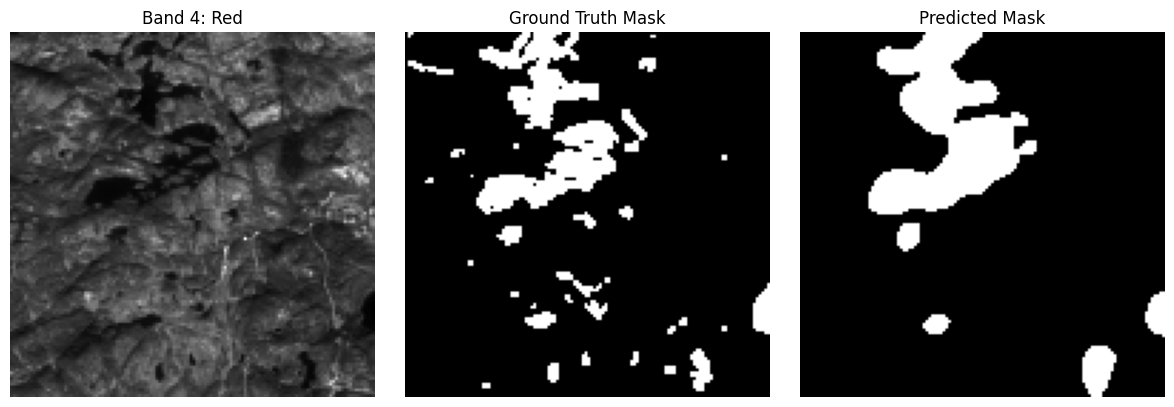

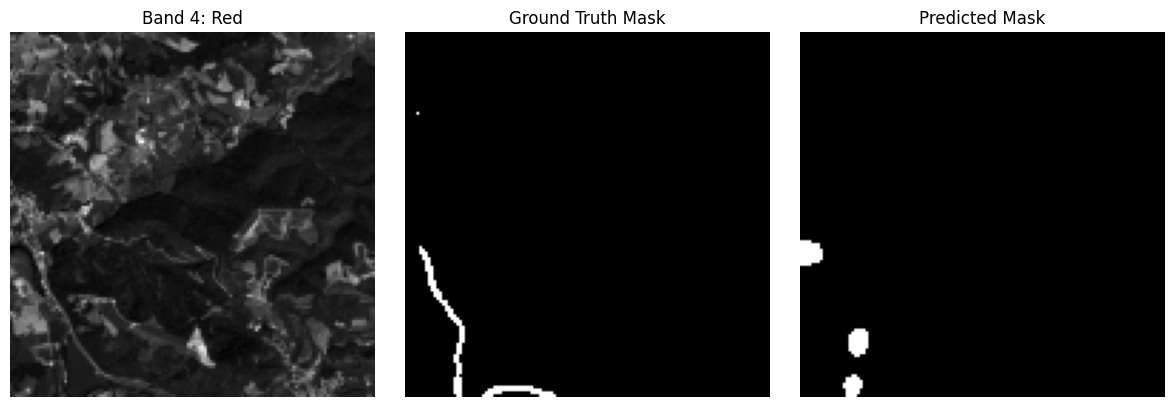

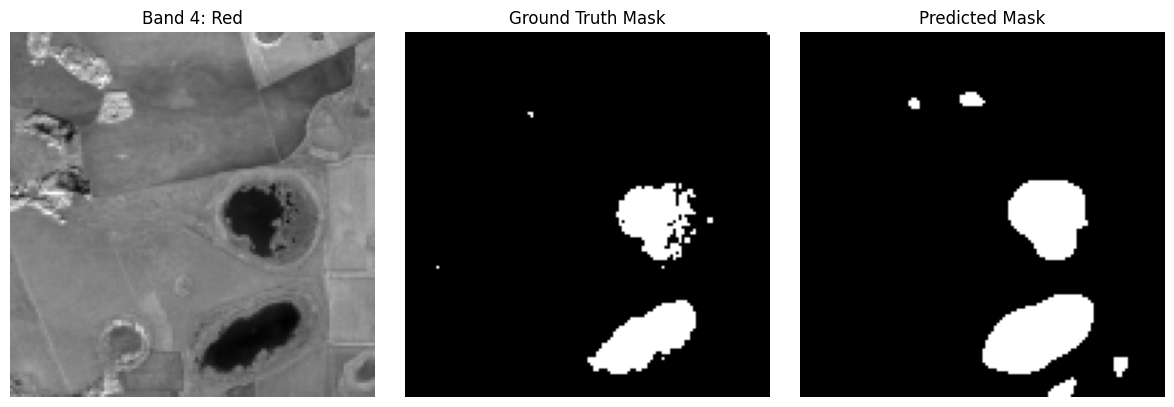

In [68]:
for i in range(3):
    image = np.load(npy_image_paths[i])       # (12, 128, 128)
    label = np.load(npy_label_paths[i])       # (128, 128)

    # To tensor
    x = torch.tensor(image, dtype=torch.float32).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        pred = model(x)
        pred = torch.sigmoid(pred).squeeze().cpu().numpy()
        pred_mask = (pred > 0.5).astype(np.uint8)

    # Plot: Red band, Ground truth, Prediction
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image[3], cmap='gray')  # Band 4 = Red
    axs[0].set_title("Band 4: Red")
    axs[0].axis('off')

    axs[1].imshow(label, cmap='gray')
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis('off')

    axs[2].imshow(pred_mask, cmap='gray')
    axs[2].set_title("Predicted Mask")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()
